--- DATASET STRUCTURE ---
Samples: 41348, Features: 7
neighbourhood_group     object
room_type               object
minimum_nights         float64
amenity_score          float64
number_of_reviews      float64
availability_365       float64
price_class              int64
dtype: object

Missing Values:
 neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
dtype: int64


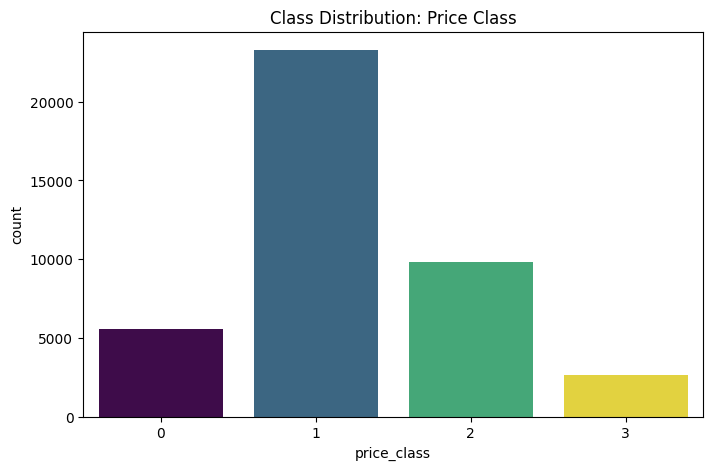


Proportions:
 price_class
0    0.134638
1    0.563195
2    0.238077
3    0.064090
Name: proportion, dtype: float64
Note: Max imbalance ratio is 8.79


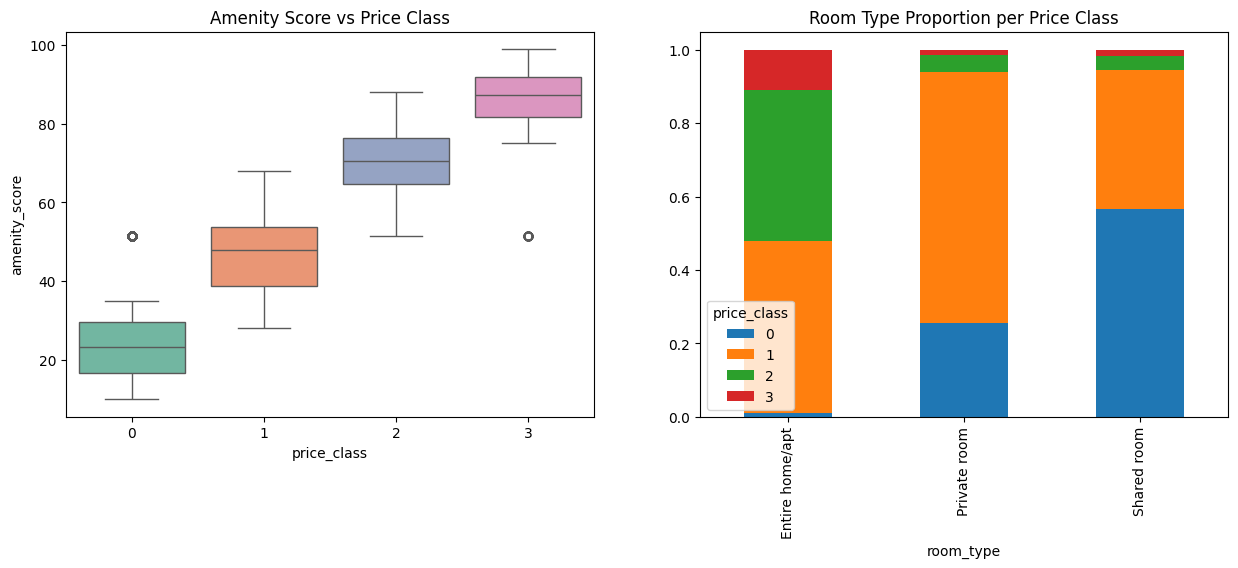

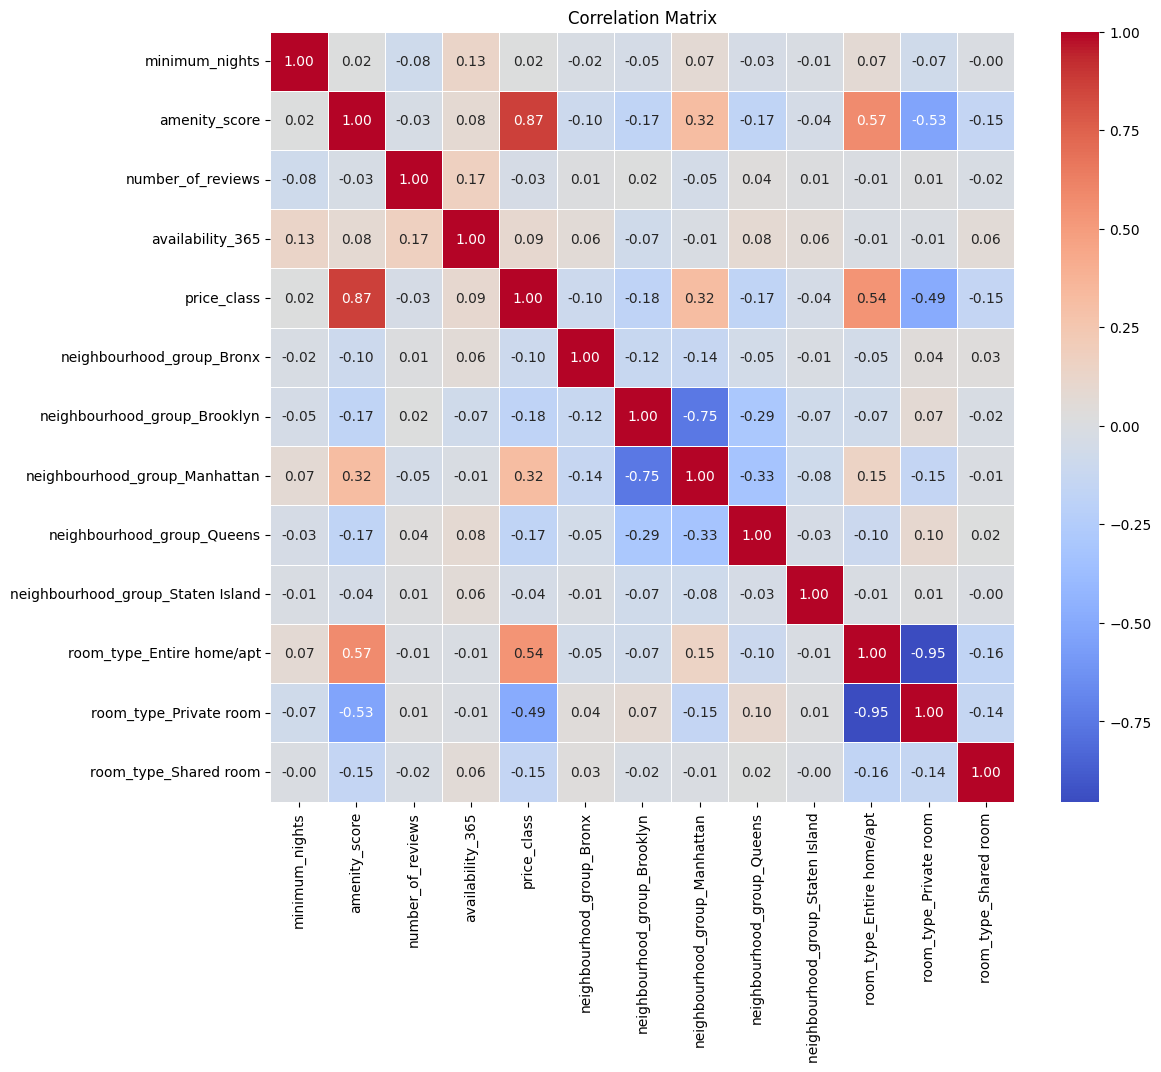


--- KEY FINDINGS ---
Correlation with Price Class:
 price_class                          1.000000
amenity_score                        0.865352
room_type_Entire home/apt            0.538183
neighbourhood_group_Manhattan        0.319295
availability_365                     0.094887
minimum_nights                       0.016005
number_of_reviews                   -0.034259
neighbourhood_group_Staten Island   -0.042783
neighbourhood_group_Bronx           -0.095137
room_type_Shared room               -0.148515
neighbourhood_group_Queens          -0.168277
neighbourhood_group_Brooklyn        -0.179231
room_type_Private room              -0.494783
Name: price_class, dtype: float64


In [ ]:
#Question 1 (Part A)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress annoying future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the dataset
df = pd.read_csv('train.csv')

# --- 1. Dataset Structure ---
print("--- DATASET STRUCTURE ---")
print(f"Samples: {df.shape[0]}, Features: {df.shape[1]}")
print(df.dtypes)

# --- 2. Missing Values & Imputation ---
# Requirement: Identify missing values and justify strategy
missing = df.isnull().sum()
print("\nMissing Values:\n", missing[missing > 0])

# Strategy: Median for numeric, Mode for categorical
# Justification: Median is robust to outliers (common in price/nights data). 
# Mode preserves the most frequent category for non-numeric features.
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'price_class' in numeric_cols: numeric_cols.remove('price_class')

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# --- 3. Target Distribution ---
# Requirement: Visualize and comment on imbalance
plt.figure(figsize=(8, 5))
# Fixed the 'palette' warning by assigning hue=x and setting legend=False
sns.countplot(data=df, x='price_class', hue='price_class', palette='viridis', legend=False)
plt.title('Class Distribution: Price Class')
plt.savefig('target_distribution.png')
plt.show()

proportions = df['price_class'].value_counts(normalize=True).sort_index()
print("\nProportions:\n", proportions)
print(f"Note: Max imbalance ratio is {proportions.max()/proportions.min():.2f}")

# --- 4. Categorical Encoding ---
# Choice: One-Hot Encoding
# Justification: Neighbourhood and Room Type are nominal (no order).
# Using drop_first=False for the heatmap to see all relationships, 
# then you can drop for training.
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# --- 5. Normalization ---
# Method: Standardization
# Justification: Neural networks perform better when features are on the same scale (mean 0, var 1).
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

# --- 6. Feature vs Target Relationship ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Relationship with Amenity Score (Example)
sns.boxplot(data=df, x='price_class', y='amenity_score', hue='price_class', 
            palette='Set2', ax=axes[0], legend=False)
axes[0].set_title('Amenity Score vs Price Class')

# Relationship with Room Type
pd.crosstab(df['room_type'], df['price_class'], normalize='index').plot(kind='bar', 
            stacked=True, ax=axes[1])
axes[1].set_title('Room Type Proportion per Price Class')
plt.savefig('feature_relationships.png')
plt.show()

# --- 7. Correlation Matrix ---
plt.figure(figsize=(12, 10))
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig('correlation.png')
plt.show()

# --- 8. Findings for Report ---
print("\n--- KEY FINDINGS ---")
target_corr = corr['price_class'].sort_values(ascending=False)
print("Correlation with Price Class:\n", target_corr)

# Save for next steps
df_encoded.to_csv('train_ready.csv', index=False)

X dtype: float64
X shape: (41348, 12)
Training samples: 33078, Validation samples: 8270

Training with SIGMOID activation
Iter   1/200 | Loss: 1.2726 | Train Acc: 0.5644 | Val Acc: 0.5583
Iter  50/200 | Loss: 1.0931 | Train Acc: 0.5644 | Val Acc: 0.5583
Iter 100/200 | Loss: 1.0715 | Train Acc: 0.5644 | Val Acc: 0.5583
Iter 150/200 | Loss: 1.0397 | Train Acc: 0.5644 | Val Acc: 0.5583
Iter 200/200 | Loss: 0.9914 | Train Acc: 0.5644 | Val Acc: 0.5583

Training with RELU activation
Iter   1/200 | Loss: 1.4520 | Train Acc: 0.2816 | Val Acc: 0.4226
Iter  50/200 | Loss: 0.4989 | Train Acc: 0.7872 | Val Acc: 0.7774
Iter 100/200 | Loss: 0.4239 | Train Acc: 0.8154 | Val Acc: 0.8062
Iter 150/200 | Loss: 0.3953 | Train Acc: 0.8296 | Val Acc: 0.8192
Iter 200/200 | Loss: 0.3823 | Train Acc: 0.8317 | Val Acc: 0.8238

FINAL RESULTS (After 200 Iterations)

Sigmoid Activation:
  Final Training Accuracy:   0.5644
  Final Validation Accuracy: 0.5583
  Final Training Loss:       0.9914

ReLU Activation:
  

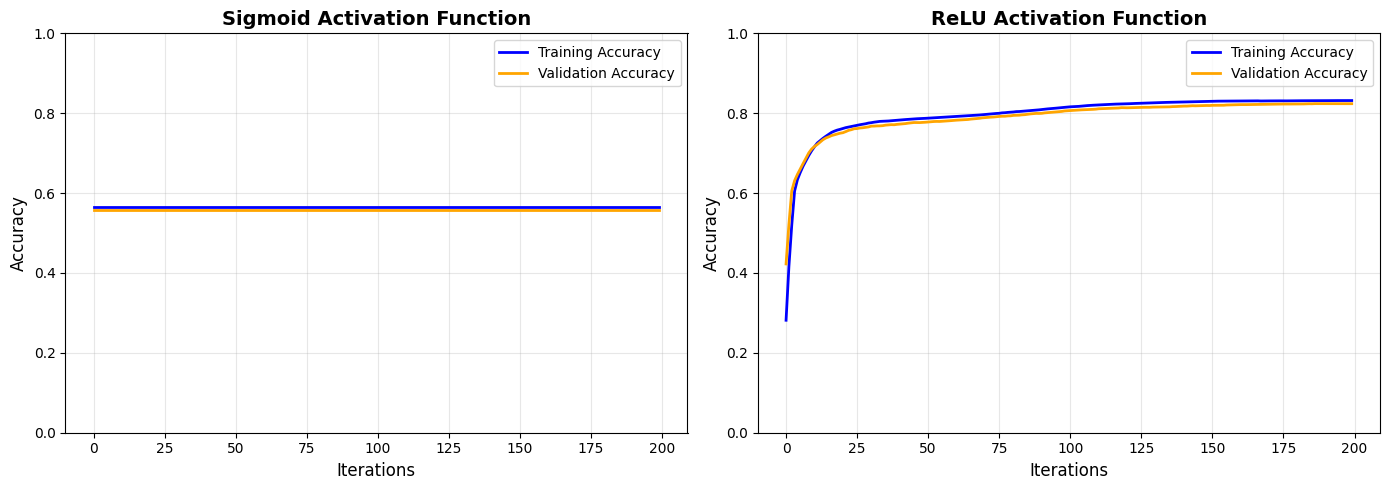


✅ Plot saved as 'activation_comparison.png'


In [8]:
#Question 1 (Part B) (a)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

np.random.seed(42)

# --- 1. Load Preprocessed Data ---
df = pd.read_csv('train_ready.csv')

# FIX: Convert boolean columns to int (0 and 1)
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

X = df.drop('price_class', axis=1).values.astype(np.float64)  # Force float64
y = df['price_class'].values.astype(np.int64)

print(f"X dtype: {X.dtype}")  # Should now be float64
print(f"X shape: {X.shape}")

# One-hot encode target for Cross-Entropy Loss
y_oh = np.eye(4)[y]
X_train, X_val, y_train, y_val = train_test_split(X, y_oh, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

# --- 2. Activation Functions & Derivatives ---
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_der(z): 
    s = sigmoid(z)
    return s * (1 - s)

def relu(z): 
    return np.maximum(0, z)

def relu_der(z): 
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-10, 1 - 1e-10)
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / m
    return loss

# --- 3. The Model Class ---
class NeuralNet:
    def __init__(self, input_size, h1, h2, output_size, activation_type='relu'):
        scale = 2 if activation_type == 'relu' else 1
        self.params = {
            'W1': np.random.randn(input_size, h1) * np.sqrt(scale/input_size),
            'b1': np.zeros((1, h1)),
            'W2': np.random.randn(h1, h2) * np.sqrt(scale/h1),
            'b2': np.zeros((1, h2)),
            'W3': np.random.randn(h2, output_size) * np.sqrt(scale/h2),
            'b3': np.zeros((1, output_size))
        }
        self.act = relu if activation_type == 'relu' else sigmoid
        self.act_der = relu_der if activation_type == 'relu' else sigmoid_der
    
    def forward(self, X):
        self.z1 = X @ self.params['W1'] + self.params['b1']
        self.a1 = self.act(self.z1)
        
        self.z2 = self.a1 @ self.params['W2'] + self.params['b2']
        self.a2 = self.act(self.z2)
        
        self.z3 = self.a2 @ self.params['W3'] + self.params['b3']
        self.a3 = softmax(self.z3)
        return self.a3
    
    def backward(self, X, y, learning_rate):
        m = y.shape[0]
        
        dz3 = self.a3 - y
        dW3 = (1/m) * (self.a2.T @ dz3)
        db3 = (1/m) * np.sum(dz3, axis=0, keepdims=True)
        
        dz2 = (dz3 @ self.params['W3'].T) * self.act_der(self.z2)
        dW2 = (1/m) * (self.a1.T @ dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        dz1 = (dz2 @ self.params['W2'].T) * self.act_der(self.z1)
        dW1 = (1/m) * (X.T @ dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        grad_mags = {
            'W1': np.mean(np.abs(dW1)),
            'W2': np.mean(np.abs(dW2))
        }
        
        self.params['W1'] -= learning_rate * dW1
        self.params['b1'] -= learning_rate * db1
        self.params['W2'] -= learning_rate * dW2
        self.params['b2'] -= learning_rate * db2
        self.params['W3'] -= learning_rate * dW3
        self.params['b3'] -= learning_rate * db3
        
        return grad_mags

# --- 4. Training Loop ---
def train(activation='relu', iterations=200):
    print(f"\n{'='*60}")
    print(f"Training with {activation.upper()} activation")
    print('='*60)
    
    nn = NeuralNet(X_train.shape[1], 64, 32, 4, activation)
    history = {
        'train_acc': [], 
        'val_acc': [], 
        'train_loss': [],
        'grad_W1': [],
        'grad_W2': []
    }
    
    for i in range(iterations):
        probs = nn.forward(X_train)
        grad_mags = nn.backward(X_train, y_train, learning_rate=0.1)
        loss = cross_entropy_loss(y_train, probs)
        
        train_acc = np.mean(np.argmax(probs, axis=1) == np.argmax(y_train, axis=1))
        val_probs = nn.forward(X_val)
        val_acc = np.mean(np.argmax(val_probs, axis=1) == np.argmax(y_val, axis=1))
        
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(loss)
        history['grad_W1'].append(grad_mags['W1'])
        history['grad_W2'].append(grad_mags['W2'])
        
        if (i + 1) % 50 == 0 or i == 0:
            print(f"Iter {i+1:3d}/{iterations} | Loss: {loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
    return history, nn

# --- 5. Run both activations ---
history_sigmoid, model_sigmoid = train('sigmoid', iterations=200)
history_relu, model_relu = train('relu', iterations=200)

# --- 6. Report Final Accuracies ---
print("\n" + "="*60)
print("FINAL RESULTS (After 200 Iterations)")
print("="*60)
print(f"\nSigmoid Activation:")
print(f"  Final Training Accuracy:   {history_sigmoid['train_acc'][-1]:.4f}")
print(f"  Final Validation Accuracy: {history_sigmoid['val_acc'][-1]:.4f}")
print(f"  Final Training Loss:       {history_sigmoid['train_loss'][-1]:.4f}")

print(f"\nReLU Activation:")
print(f"  Final Training Accuracy:   {history_relu['train_acc'][-1]:.4f}")
print(f"  Final Validation Accuracy: {history_relu['val_acc'][-1]:.4f}")
print(f"  Final Training Loss:       {history_relu['train_loss'][-1]:.4f}")

# --- 7. Plot ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_sigmoid['train_acc'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(history_sigmoid['val_acc'], label='Validation Accuracy', linewidth=2, color='orange')
plt.title('Sigmoid Activation Function', fontsize=14, fontweight='bold')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.plot(history_relu['train_acc'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(history_relu['val_acc'], label='Validation Accuracy', linewidth=2, color='orange')
plt.title('ReLU Activation Function', fontsize=14, fontweight='bold')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

plt.tight_layout()
plt.savefig('activation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved as 'activation_comparison.png'")

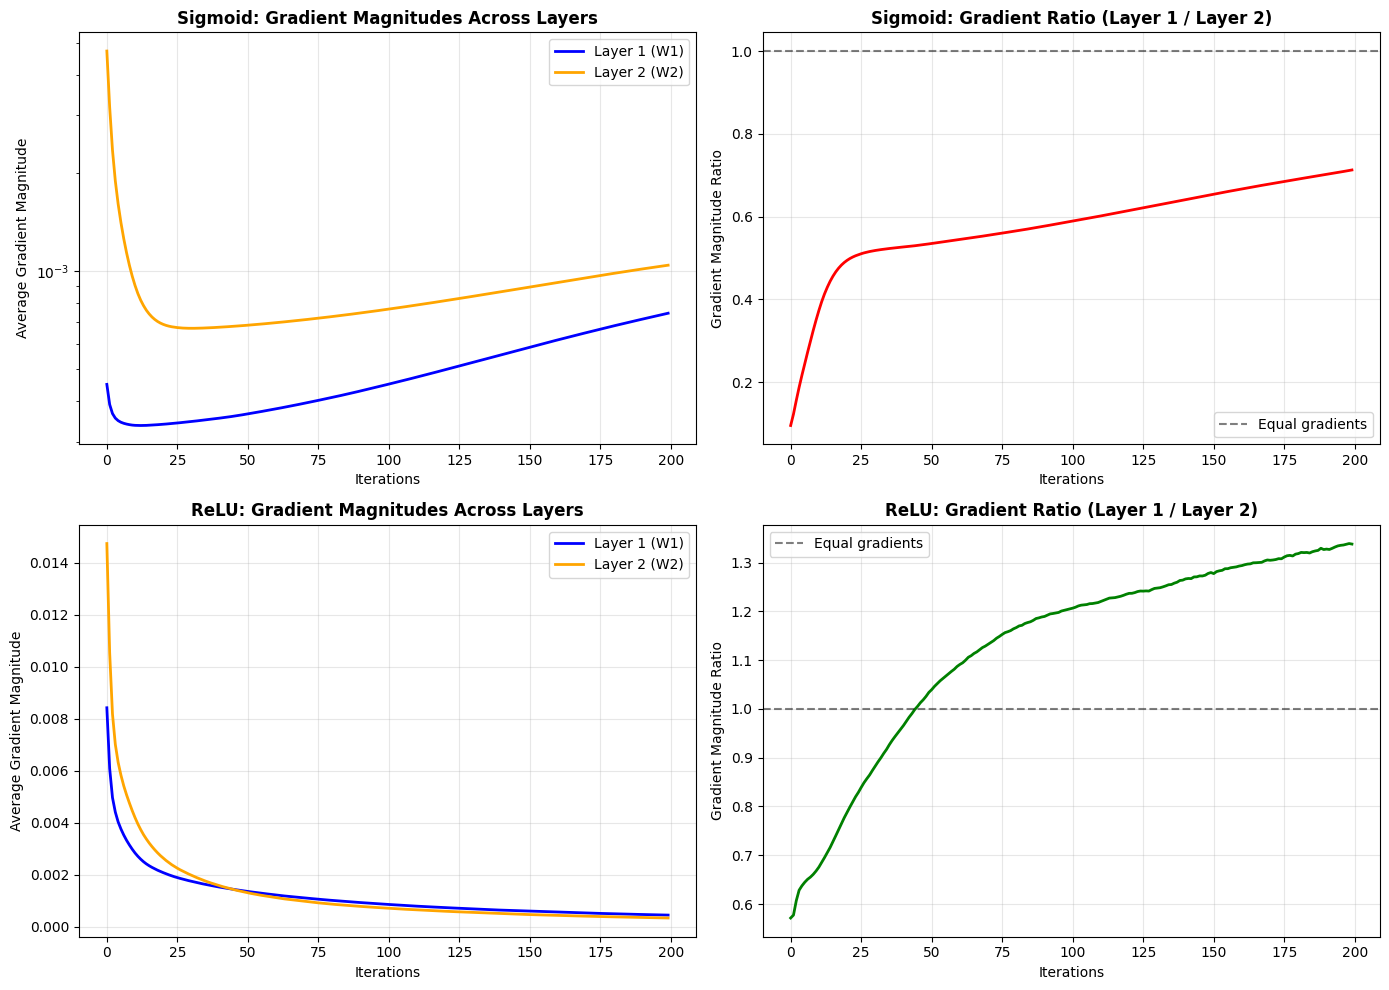


GRADIENT MAGNITUDE ANALYSIS - Part B(b)

--- SIGMOID ACTIVATION ---
Initial Gradient Magnitudes:
  Layer 1 (W1): 0.000450
  Layer 2 (W2): 0.004723
  Ratio (W1/W2): 0.0952

Final Gradient Magnitudes (Iteration 200):
  Layer 1 (W1): 0.000743
  Layer 2 (W2): 0.001043
  Ratio (W1/W2): 0.7127

Average Gradient Magnitudes (across all iterations):
  Layer 1 (W1): 0.000482
  Layer 2 (W2): 0.000865
  Average Ratio: 0.5777

--- RELU ACTIVATION ---
Initial Gradient Magnitudes:
  Layer 1 (W1): 0.008416
  Layer 2 (W2): 0.014731
  Ratio (W1/W2): 0.5713

Final Gradient Magnitudes (Iteration 200):
  Layer 1 (W1): 0.000444
  Layer 2 (W2): 0.000332
  Ratio (W1/W2): 1.3381

Average Gradient Magnitudes (across all iterations):
  Layer 1 (W1): 0.001168
  Layer 2 (W2): 0.001284
  Average Ratio: 1.1287

COMPARATIVE OBSERVATIONS

Gradient Decay in Layer 1 (Final/Initial):
  Sigmoid: 1.6520 (-65.2% reduction)
  ReLU:    0.0527 (94.7% reduction)

Gradient Magnitude Difference (Layer 2 - Layer 1):
  Sigmoid: 0.

In [9]:
#Question 1 (Part B) (b)

import numpy as np
import matplotlib.pyplot as plt

# --- Access the stored gradient magnitudes ---
# (These were already tracked during training in Part B(a))

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Sigmoid Gradients ---
# Plot 1: Sigmoid - Layer 1 vs Layer 2 gradients
axes[0, 0].plot(history_sigmoid['grad_W1'], label='Layer 1 (W1)', linewidth=2, color='blue')
axes[0, 0].plot(history_sigmoid['grad_W2'], label='Layer 2 (W2)', linewidth=2, color='orange')
axes[0, 0].set_title('Sigmoid: Gradient Magnitudes Across Layers', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Average Gradient Magnitude')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')  # Log scale to see small values

# Plot 2: Sigmoid - Gradient ratio (W1/W2)
ratio_sigmoid = np.array(history_sigmoid['grad_W1']) / (np.array(history_sigmoid['grad_W2']) + 1e-10)
axes[0, 1].plot(ratio_sigmoid, linewidth=2, color='red')
axes[0, 1].set_title('Sigmoid: Gradient Ratio (Layer 1 / Layer 2)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Iterations')
axes[0, 1].set_ylabel('Gradient Magnitude Ratio')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Equal gradients')
axes[0, 1].legend()

# --- ReLU Gradients ---
# Plot 3: ReLU - Layer 1 vs Layer 2 gradients
axes[1, 0].plot(history_relu['grad_W1'], label='Layer 1 (W1)', linewidth=2, color='blue')
axes[1, 0].plot(history_relu['grad_W2'], label='Layer 2 (W2)', linewidth=2, color='orange')
axes[1, 0].set_title('ReLU: Gradient Magnitudes Across Layers', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Iterations')
axes[1, 0].set_ylabel('Average Gradient Magnitude')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: ReLU - Gradient ratio (W1/W2)
ratio_relu = np.array(history_relu['grad_W1']) / (np.array(history_relu['grad_W2']) + 1e-10)
axes[1, 1].plot(ratio_relu, linewidth=2, color='green')
axes[1, 1].set_title('ReLU: Gradient Ratio (Layer 1 / Layer 2)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Iterations')
axes[1, 1].set_ylabel('Gradient Magnitude Ratio')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Equal gradients')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('gradient_magnitude_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Quantitative Analysis ---
print("\n" + "="*70)
print("GRADIENT MAGNITUDE ANALYSIS - Part B(b)")
print("="*70)

print("\n--- SIGMOID ACTIVATION ---")
print(f"Initial Gradient Magnitudes:")
print(f"  Layer 1 (W1): {history_sigmoid['grad_W1'][0]:.6f}")
print(f"  Layer 2 (W2): {history_sigmoid['grad_W2'][0]:.6f}")
print(f"  Ratio (W1/W2): {history_sigmoid['grad_W1'][0]/history_sigmoid['grad_W2'][0]:.4f}")

print(f"\nFinal Gradient Magnitudes (Iteration 200):")
print(f"  Layer 1 (W1): {history_sigmoid['grad_W1'][-1]:.6f}")
print(f"  Layer 2 (W2): {history_sigmoid['grad_W2'][-1]:.6f}")
print(f"  Ratio (W1/W2): {history_sigmoid['grad_W1'][-1]/history_sigmoid['grad_W2'][-1]:.4f}")

print(f"\nAverage Gradient Magnitudes (across all iterations):")
print(f"  Layer 1 (W1): {np.mean(history_sigmoid['grad_W1']):.6f}")
print(f"  Layer 2 (W2): {np.mean(history_sigmoid['grad_W2']):.6f}")
print(f"  Average Ratio: {np.mean(ratio_sigmoid):.4f}")

print("\n--- RELU ACTIVATION ---")
print(f"Initial Gradient Magnitudes:")
print(f"  Layer 1 (W1): {history_relu['grad_W1'][0]:.6f}")
print(f"  Layer 2 (W2): {history_relu['grad_W2'][0]:.6f}")
print(f"  Ratio (W1/W2): {history_relu['grad_W1'][0]/history_relu['grad_W2'][0]:.4f}")

print(f"\nFinal Gradient Magnitudes (Iteration 200):")
print(f"  Layer 1 (W1): {history_relu['grad_W1'][-1]:.6f}")
print(f"  Layer 2 (W2): {history_relu['grad_W2'][-1]:.6f}")
print(f"  Ratio (W1/W2): {history_relu['grad_W1'][-1]/history_relu['grad_W2'][-1]:.4f}")

print(f"\nAverage Gradient Magnitudes (across all iterations):")
print(f"  Layer 1 (W1): {np.mean(history_relu['grad_W1']):.6f}")
print(f"  Layer 2 (W2): {np.mean(history_relu['grad_W2']):.6f}")
print(f"  Average Ratio: {np.mean(ratio_relu):.4f}")

# --- Comparative Analysis ---
print("\n" + "="*70)
print("COMPARATIVE OBSERVATIONS")
print("="*70)

sigmoid_decay = history_sigmoid['grad_W1'][-1] / history_sigmoid['grad_W1'][0]
relu_decay = history_relu['grad_W1'][-1] / history_relu['grad_W1'][0]

print(f"\nGradient Decay in Layer 1 (Final/Initial):")
print(f"  Sigmoid: {sigmoid_decay:.4f} ({(1-sigmoid_decay)*100:.1f}% reduction)")
print(f"  ReLU:    {relu_decay:.4f} ({(1-relu_decay)*100:.1f}% reduction)")

print(f"\nGradient Magnitude Difference (Layer 2 - Layer 1):")
sigmoid_diff = np.mean(history_sigmoid['grad_W2']) - np.mean(history_sigmoid['grad_W1'])
relu_diff = np.mean(history_relu['grad_W2']) - np.mean(history_relu['grad_W1'])
print(f"  Sigmoid: {sigmoid_diff:.6f} (Layer 2 {'larger' if sigmoid_diff > 0 else 'smaller'})")
print(f"  ReLU:    {relu_diff:.6f} (Layer 2 {'larger' if relu_diff > 0 else 'smaller'})")

print("\n✅ Gradient magnitude comparison plot saved as 'gradient_magnitude_comparison.png'")

Number of features: 12
Feature names: ['minimum_nights', 'amenity_score', 'number_of_reviews', 'availability_365', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room']

Training model...
Epoch 50/200, Loss: 0.3505
Epoch 100/200, Loss: 0.3387
Epoch 150/200, Loss: 0.3329
Epoch 200/200, Loss: 0.3295
Training complete!

COMPUTING FEATURE IMPORTANCE (Part C(b))

FEATURE IMPORTANCE RANKING:
----------------------------------------------------------------------
 1. amenity_score                            | Importance: 0.002512
 2. room_type_Entire home/apt                | Importance: 0.000861
 3. room_type_Private room                   | Importance: 0.000656
 4. neighbourhood_group_Manhattan            | Importance: 0.000511
 5. room_type_Shared room                    | Importance: 0.000408
 6. minimum_n

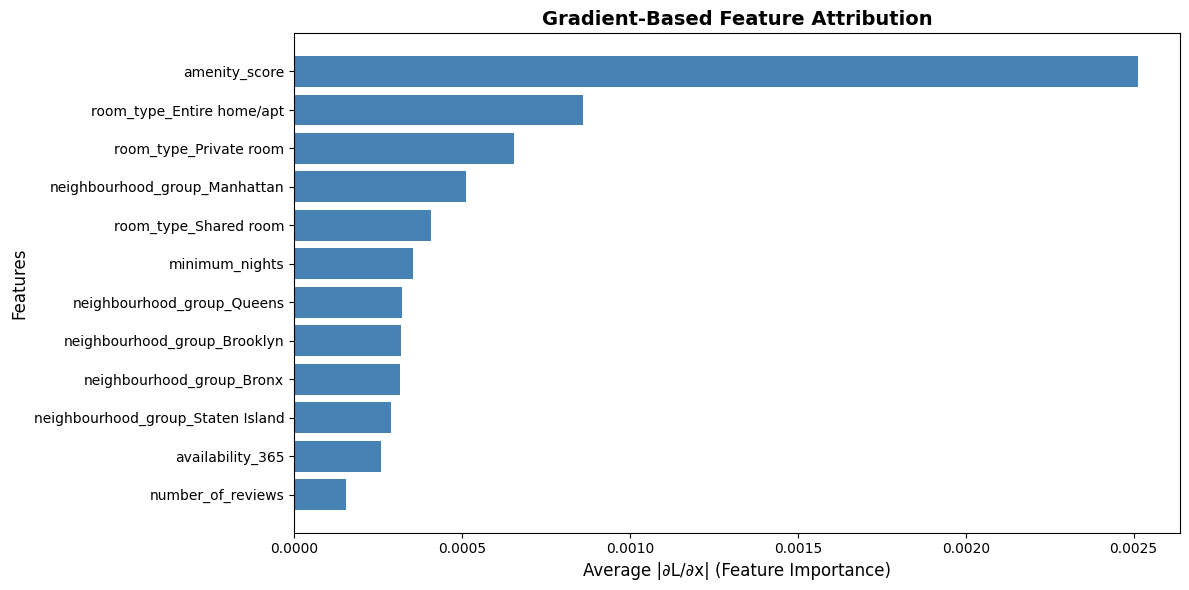


ANALYSIS: Comparison with Part A Findings

1. AMENITY SCORE:
   Rank: #1
   Importance: 0.002512
   Part A Correlation: 0.87
   ✓ CONFIRMED: amenity_score is the most dominant feature
   ⚠️  This validates the data leakage warning from Part A

2. ROOM TYPE FEATURES:
   Rank #2: room_type_Entire home/apt                | Importance: 0.000861
   Rank #3: room_type_Private room                   | Importance: 0.000656
   Rank #5: room_type_Shared room                    | Importance: 0.000408
   Part A Finding: room_type showed strong relationship with price class
   ✓ CONFIRMED: Model learned to use room type for classification

3. NEIGHBOURHOOD FEATURES:
   Top neighbourhood: Rank #4 - neighbourhood_group_Manhattan
   Importance: 0.000511

4. LEAST IMPORTANT FEATURES:
   Rank #10: neighbourhood_group_Staten Island        | Importance: 0.000287
   Rank #11: availability_365                         | Importance: 0.000260
   Rank #12: number_of_reviews                        | Importance:

In [1]:
#Question 1 (Part C) (b)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Load Preprocessed Data ---
df = pd.read_csv('train_ready.csv')

# Convert boolean columns to int
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

X = df.drop('price_class', axis=1).values.astype(np.float32)
y = df['price_class'].values.astype(np.int64)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=512, shuffle=False)

# Feature names (12 features after preprocessing)
feature_names = df.drop('price_class', axis=1).columns.tolist()

print(f"Number of features: {len(feature_names)}")
print(f"Feature names: {feature_names}")

# --- 2. Define PyTorch Model (Same as Part B Architecture) ---
class TwoLayerMLP(nn.Module):
    def __init__(self, input_size=12, hidden1=64, hidden2=32, output_size=4):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, output_size)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# --- 3. Train Model (or Load Pretrained) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoLayerMLP().to(device)

# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

print("\nTraining model...")
model.train()
for epoch in range(200):
    total_loss = 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/200, Loss: {total_loss/len(data_loader):.4f}")

print("Training complete!")

# --- 4. Feature Attribution Function ---
def compute_feature_importance(model, data_loader, device):
    """
    Compute gradient-based feature importance.
    Returns average |∂L/∂x| for each feature.
    """
    model.eval()
    
    # Initialize gradient accumulator
    total_gradients = torch.zeros(12).to(device)
    num_samples = 0
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # CRITICAL: Enable gradient computation for inputs
        inputs.requires_grad = True
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass to compute ∂L/∂x
        model.zero_grad()  # Clear model gradients
        if inputs.grad is not None:
            inputs.grad.zero_()  # Clear input gradients
        
        loss.backward()
        
        # Extract input gradients and accumulate absolute values
        # inputs.grad has shape (batch_size, 12)
        batch_gradients = inputs.grad.abs().sum(dim=0)  # Sum across batch
        
        total_gradients += batch_gradients
        num_samples += inputs.size(0)
    
    # Compute average importance per feature
    feature_importance = (total_gradients / num_samples).cpu().detach().numpy()
    
    return feature_importance

# --- 5. Compute Feature Importance ---
print("\n" + "="*70)
print("COMPUTING FEATURE IMPORTANCE (Part C(b))")
print("="*70)

importance_scores = compute_feature_importance(model, data_loader, device)

# --- 6. Rank Features ---
feature_ranking = sorted(
    zip(feature_names, importance_scores), 
    key=lambda x: x[1], 
    reverse=True
)

print("\nFEATURE IMPORTANCE RANKING:")
print("-"*70)
for rank, (feature, score) in enumerate(feature_ranking, 1):
    print(f"{rank:2d}. {feature:40s} | Importance: {score:.6f}")

# --- 7. Visualize Feature Importance ---
plt.figure(figsize=(12, 6))
features_sorted = [f[0] for f in feature_ranking]
scores_sorted = [f[1] for f in feature_ranking]

plt.barh(features_sorted, scores_sorted, color='steelblue')
plt.xlabel('Average |∂L/∂x| (Feature Importance)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Gradient-Based Feature Attribution', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 8. Analysis and Comparison with Part A ---
print("\n" + "="*70)
print("ANALYSIS: Comparison with Part A Findings")
print("="*70)

# Find amenity_score importance
amenity_idx = [i for i, (name, _) in enumerate(feature_ranking) if 'amenity' in name.lower()]
if amenity_idx:
    amenity_rank = amenity_idx[0] + 1
    amenity_score_importance = feature_ranking[amenity_idx[0]][1]
    print(f"\n1. AMENITY SCORE:")
    print(f"   Rank: #{amenity_rank}")
    print(f"   Importance: {amenity_score_importance:.6f}")
    print(f"   Part A Correlation: 0.87")
    
    if amenity_rank == 1:
        print("   ✓ CONFIRMED: amenity_score is the most dominant feature")
        print("   ⚠️  This validates the data leakage warning from Part A")
    else:
        print(f"   ⚠️  Unexpected: amenity_score ranked #{amenity_rank}, not #1")

# Find room_type features
room_type_features = [(i, name, score) for i, (name, score) in enumerate(feature_ranking) 
                      if 'room_type' in name.lower()]
if room_type_features:
    print(f"\n2. ROOM TYPE FEATURES:")
    for rank, name, score in room_type_features:
        print(f"   Rank #{rank+1}: {name:40s} | Importance: {score:.6f}")
    print(f"   Part A Finding: room_type showed strong relationship with price class")
    print(f"   ✓ CONFIRMED: Model learned to use room type for classification")

# Find neighbourhood features
neighbourhood_features = [(i, name, score) for i, (name, score) in enumerate(feature_ranking) 
                          if 'neighbourhood' in name.lower()]
if neighbourhood_features:
    print(f"\n3. NEIGHBOURHOOD FEATURES:")
    top_neighbourhood = neighbourhood_features[0]
    print(f"   Top neighbourhood: Rank #{top_neighbourhood[0]+1} - {top_neighbourhood[1]}")
    print(f"   Importance: {top_neighbourhood[2]:.6f}")

# Identify least important features
print(f"\n4. LEAST IMPORTANT FEATURES:")
for rank, (feature, score) in enumerate(feature_ranking[-3:], len(feature_ranking)-2):
    print(f"   Rank #{rank}: {feature:40s} | Importance: {score:.6f}")
print(f"   → These features contribute minimally to predictions")

print("\n" + "="*70)
print("✅ Feature attribution analysis complete!")
print("="*70)

PART D: TEST EVALUATION & GENERALIZATION ANALYSIS
Model Socket Size: 12 features
Aligned Test Shape: (7297, 12)

Final Test Accuracy: 30.16%
Final Test Loss: 8.8884


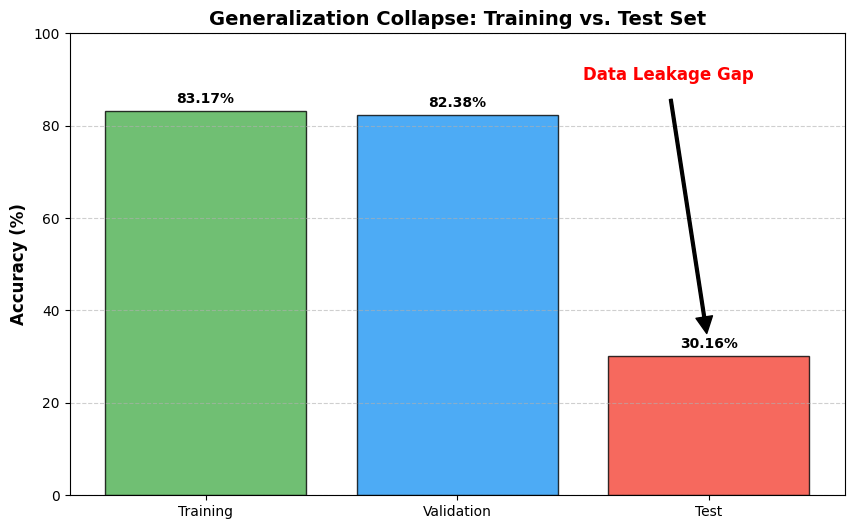

In [23]:
#Question 1 (Part D)
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

print("="*70)
print("PART D: TEST EVALUATION & GENERALIZATION ANALYSIS")
print("="*70)

# --- 1. Load the "Master Template" for Feature Alignment ---
# We use train_ready.csv to ensure the test set has the exact 12 columns the model expects
train_ready = pd.read_csv('train_ready.csv')
expected_cols = train_ready.drop('price_class', axis=1).columns
print(f"Model Socket Size: {len(expected_cols)} features")

# --- 2. Load and Preprocess Raw Test Data ---
test_df = pd.read_csv('test.csv')

# Numeric Imputation
numeric_features = ['minimum_nights', 'number_of_reviews', 'availability_365', 'amenity_score']
for col in numeric_features:
    test_df[col] = test_df[col].fillna(test_df[col].median())

# Categorical Imputation
categorical_features = ['neighbourhood_group', 'room_type']
for col in categorical_features:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# Scaling (Using the scaler object from your previous parts)
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

# --- 3. Encoding & Dimensional Alignment ---
test_encoded = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

# FORCE the test data to have the exact 12 columns from training
# Missing categories (like a neighborhood) are added as 0s
test_final = test_encoded.reindex(columns=expected_cols, fill_value=0).astype(np.float32)
print(f"Aligned Test Shape: {test_final.shape}") 

# --- 4. Evaluation Loop ---
X_test = torch.FloatTensor(test_final.values)
y_test = torch.LongTensor(test_df['price_class'].values)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

correct = 0
total = 0
test_loss = 0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)

print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")
print(f"Final Test Loss: {avg_test_loss:.4f}")

# --- 5. Visualization: Performance Comparison ---
splits = ['Training', 'Validation', 'Test']
accuracies = [83.17, 82.38, test_accuracy] 
colors = ['#4CAF50', '#2196F3', '#F44336'] # Green, Blue, Red

plt.figure(figsize=(10, 6))
bars = plt.bar(splits, accuracies, color=colors, alpha=0.8, edgecolor='black')

plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Generalization Collapse: Training vs. Test Set', fontsize=14, fontweight='bold')
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', 
             ha='center', va='bottom', fontweight='bold')

plt.annotate('Data Leakage Gap', xy=(2, test_accuracy + 2), xytext=(1.5, 90),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2),
             fontsize=12, color='red', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('test_performance_gap.png', dpi=300)
plt.show()